In [ ]:
#Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import plotly.express as px
import seaborn as sns

In [16]:
from geopy.distance import geodesic

In [17]:
#settings
sns.set_style("whitegrid")

# Data Cleaning

In [18]:
# Load Outscraper data
df = pd.read_excel("/Users/joegould/Programming/Erdos/data-science-spring-2025/Project/rawData/outscraper.xlsx")



In [19]:
#Basic data cleaning 

# Drop cols with more than 95% missing values
threshold = 95
df_cleaned = df.loc[:, df.isnull().mean() * 100 < threshold]

# Drop rows with missing ratings or reviews
df_cleaned = df_cleaned.dropna(subset=['rating', 'reviews'])

# Keep only rows where 'verified' is True
df_cleaned = df_cleaned[df_cleaned['verified'] == True]

# Get rid of NJ restaurants
df_cleaned = df_cleaned.loc[df_cleaned.state.isin(["PA", "pa", "Pennsylvania", "pennsylvania"])]

#restrict latitude range to get rid of NYC restaurants 
df_cleaned = df_cleaned.loc[(df_cleaned.latitude < 40.3) & (df_cleaned.latitude > 39.85) ]

In [20]:
#Clean up some columns:
#1. make range numeric for analysis
#2. make sure counting columns are integers
#3. one-hot encode the subtypes of the restaurants

# Convert 'range' to numeric 'price_range'
range_mapping = {'$': 1, '$$': 2, '$$$': 3, '$$$$': 4}
df_cleaned['price_range'] = df_cleaned['range'].map(range_mapping)

# Convert counting columns to integer
df_cleaned['reviews'] = df_cleaned['reviews'].astype(int)
df_cleaned['reviews_per_score_1'] = df_cleaned['reviews_per_score_1'].astype(int)
df_cleaned['reviews_per_score_2'] = df_cleaned['reviews_per_score_2'].astype(int)
df_cleaned['reviews_per_score_3'] = df_cleaned['reviews_per_score_3'].astype(int)
df_cleaned['reviews_per_score_4'] = df_cleaned['reviews_per_score_4'].astype(int)
df_cleaned['reviews_per_score_5'] = df_cleaned['reviews_per_score_5'].astype(int)

# One-hot encode 'subtypes'
# Fill NaNs with empty strings
df_cleaned['subtypes'] = df_cleaned['subtypes'].fillna('')

# Split subtypes into lists
df_cleaned['subtypes_list'] = df_cleaned['subtypes'].apply( lambda x: [s.strip() for s in x.split(',') if s.strip()])

# Use MultiLabelBinarizer for one-hot encoding
mlb = sk.preprocessing.MultiLabelBinarizer()
subtypes_encoded = pd.DataFrame(
    mlb.fit_transform(df_cleaned['subtypes_list']),
    columns=mlb.classes_,
    index=df_cleaned.index
)

# Merge one-hot encoded subtypes with the main DataFrame
df_cleaned = pd.concat([df_cleaned, subtypes_encoded], axis=1)

# Test Train Split

In [21]:
df_train, df_test = sk.model_selection.train_test_split(df_cleaned, shuffle = True, test_size = .2)

# Location Analysis

In [22]:
fig = px.density_mapbox(df_train, lat='latitude', lon='longitude', z='rating', radius=2,
                        center=dict(lat=40, lon=-75), zoom=10,
                        mapbox_style="open-street-map")
fig.show()

In [23]:
#COMPUTE DISTANCE TO CITY HALL, AND SEE HOW THAT RELATES TO RESTAURANT RATING

# Define City Hall coordinates (Center City, Philadelphia)
city_center_coords = (39.9526, -75.1652)  # (lat, lon)

# Compute distance to City Hall and create new feature column
df_train['city_hall_distance_km'] = df_train.apply(
    lambda row: geodesic(city_center_coords, (row['latitude'], row['longitude'])).kilometers,
    axis=1
)

# Check correlation between distance and rating
correlation = df_train[['city_hall_distance_km', 'rating']].corr().loc['city_hall_distance_km', 'rating']
print("Correlation between city hall distance and rating", correlation)

Correlation between city hall distance and rating -0.11627137958148631


In [25]:
#KNN regression

# Set number of neighbors
k = 10

# Fit Nearest Neighbors model
knn = sk.neighbors.KNeighborsRegressor(k)  
knn.fit(df_train[['latitude', 'longitude']], df_train.rating)

# Check RMSE
sk.metrics.root_mean_squared_error(df_train.rating, knn.predict(df_train[['latitude', 'longitude']]))

0.4473105219197669

In [ ]:
#quality relative to neighbors as a metric

# Add new features to the DataFrame
df_train['neighbor_avg_rating'] = knn.predict(df_train[['latitude', 'longitude']])
df_train['rating_minus_local_avg'] = df_train['rating'] - df_train['neighbor_avg_rating']

# Preview the new features
print(df_train[['name', 'rating', 'neighbor_avg_rating', 'rating_minus_local_avg']].head())

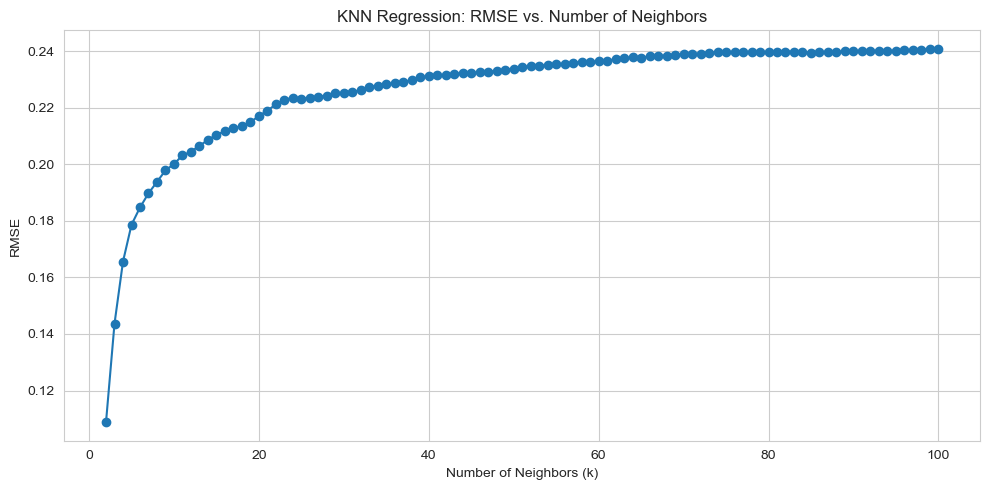

In [ ]:
#Test different value of k

# grab features and target
X = df_train[['latitude', 'longitude']]
y = df_train['rating']

# Store RMSE values for different k
rmse_values = np.zeros(99)

# Evaluate KNN regressor for each k
for k in range(2,101):
    knn = sk.neighbors.KNeighborsRegressor(k)
    knn.fit(X,y)
    y_pred = knn.predict(X)
    rmse = sk.metrics.mean_squared_error(y, y_pred)
    rmse_values[k-2] = rmse

# Find optimal k with lowest RMSE
# min_rmse = min(rmse_values)
# optimal_k = k_values[rmse_values.index(min_rmse)]
# print(f"Lowest RMSE: {min_rmse:.3f} at k = {optimal_k}")

# Plot RMSE vs. k
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(2, 100, 99), rmse_values, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.title('KNN Regression: RMSE vs. Number of Neighbors')
plt.grid(True)
plt.tight_layout()
plt.show()

#might also want to try using a radius regression or something. probably makes more sense at the end of the day.

                                     name  rating  neighbor_avg_rating  \
174   El Meson Latin American Cuisine bar     3.7                 4.28   
832                         King of Pizza     4.7                 4.19   
733    Happy Lifestyle Energy & Nutrition     5.0                 3.92   
1335                   Joe's Pizza Philly     4.4                 4.37   
2924                 The Crazy Leprechaun     4.2                 4.30   

      rating_minus_local_avg  
174                    -0.58  
832                     0.51  
733                     1.08  
1335                    0.03  
2924                   -0.10  


In [ ]:
#Moran's I
import geopandas as gpd
from libpysal.weights import KNN
from esda.moran import Moran

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_train,
    geometry=gpd.points_from_xy(df_train['longitude'], df_train['latitude']),
    crs="EPSG:4326"
)

# Construct K-Nearest Neighbor weights (k=25) (this could be tweaked)
w = KNN.from_dataframe(gdf, k=25)
w.transform = 'R'  # Row-standardized weights

# Calculate Moran’s I for the rating column
moran = Moran(gdf['rating'], w)

print("Moran's I:", moran.I)
print("p-value (randomization):", moran.p_sim)

# weak-to-modest positive spatial correlation. very stastically signicant. 

Moran's I: 0.12538528434135268
p-value (randomization): 0.001


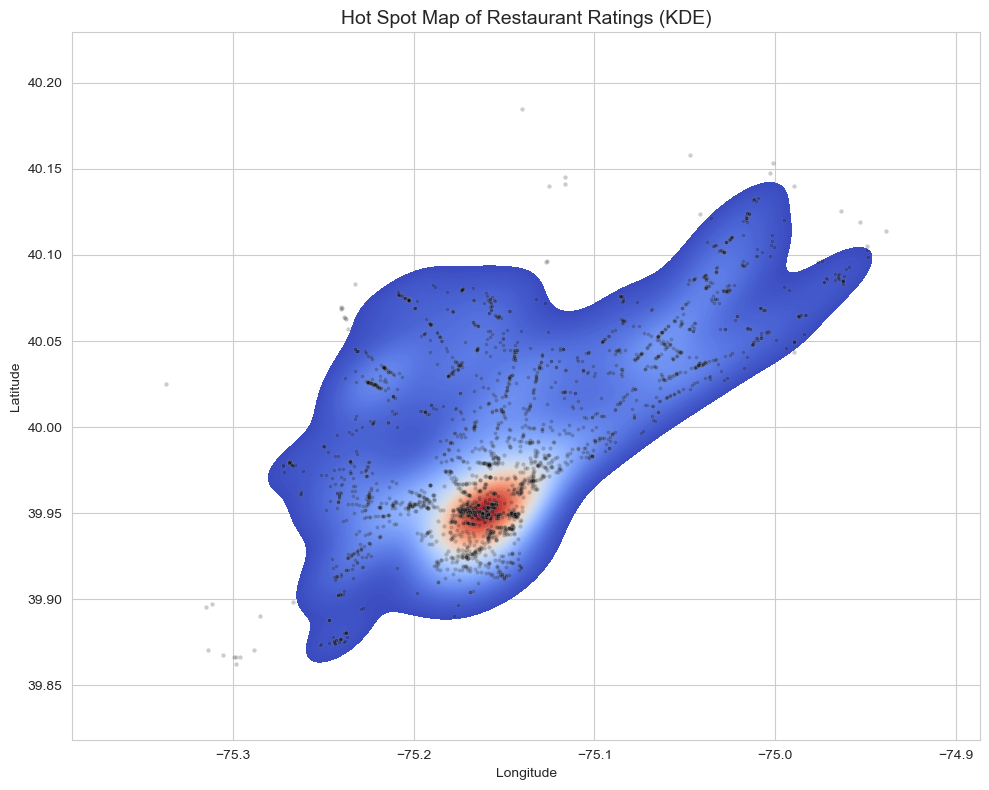

In [ ]:

#Kernel Density Estimate of rating

plt.figure(figsize=(10, 8))

# Plot KDE heatmap of restaurant density weighted by rating
sns.kdeplot(
    x=df_train['longitude'],
    y=df_train['latitude'],
    weights=df_train['rating'],
    cmap="coolwarm",
    fill=True,
    thresh=0.05,
    levels=100
)

# Add scatter of restaurant locations
sns.scatterplot(
    x=df_train['longitude'],
    y=df_train['latitude'],
    color='black',
    alpha=0.2,
    s=10
)

plt.title('Hot Spot Map of Restaurant Ratings (KDE)', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.show()

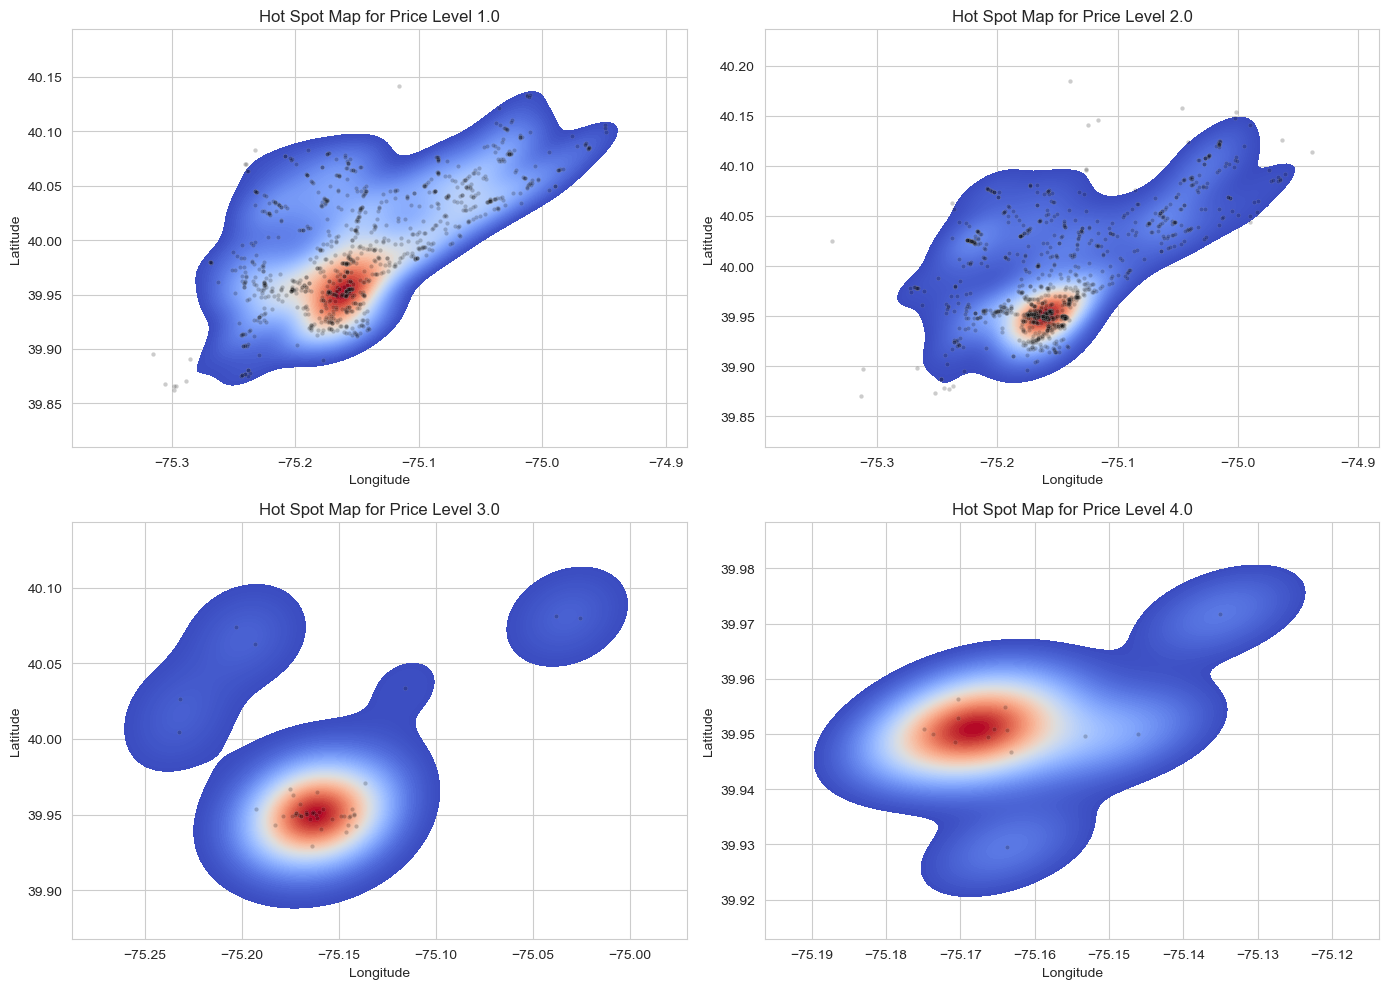

In [ ]:
#KDE by price

# Filter out restaurants with missing price range
df_price_filtered = df_train.dropna(subset=['price_range'])

# Create plots
plt.figure(figsize=(14, 10))
price_levels = sorted(df_price_filtered['price_range'].unique())

for i, price in enumerate(price_levels, 1):
    plt.subplot(2, 2, i)
    subset = df_price_filtered[df_price_filtered['price_range'] == price]
    
    # KDE plot for current price range
    sns.kdeplot(
        x=subset['longitude'],
        y=subset['latitude'],
        weights=subset['rating'],
        cmap="coolwarm",
        fill=True,
        thresh=0.05,
        levels=100
    )
    
    # Overlay scatter of restaurant locations
    sns.scatterplot(
        x=subset['longitude'],
        y=subset['latitude'],
        color='black',
        alpha=0.2,
        s=10
    )
    
    plt.title(f'Hot Spot Map for Price Level {price}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

plt.tight_layout()
plt.show()


#this lookes to me more like there are different prices of restaurants in different areas. 

# Exploring some variables

/var/folders/_1/_rvxnt1x21z75rz6bqsg1x580000gn/T/ipykernel_13437/237241712.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




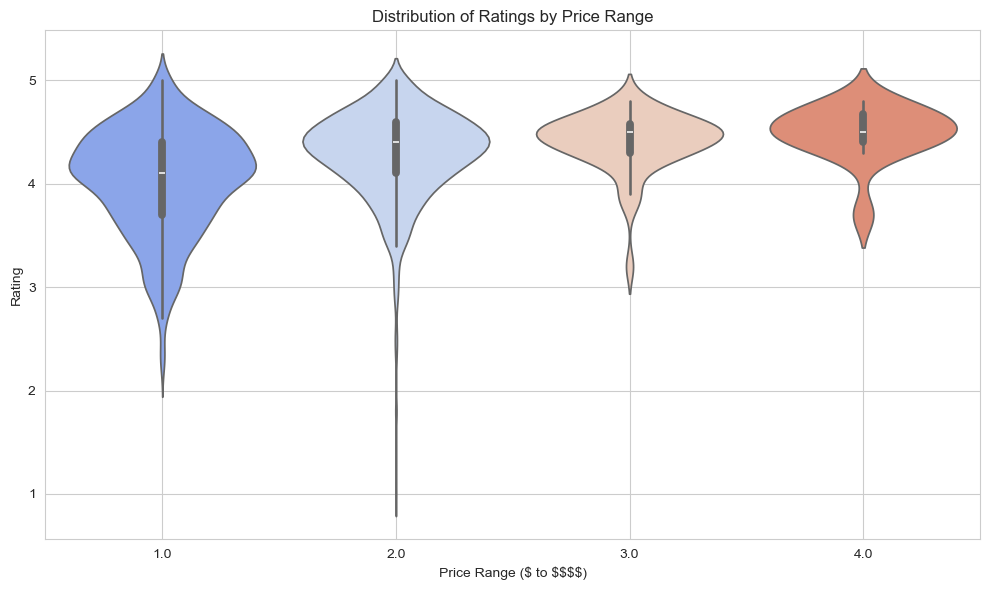

In [46]:
plt.figure(figsize=(10, 6))

# Violin plot of rating by price range
sns.violinplot(
    x='price_range',
    y='rating',
    data=df_price_filtered,
    inner='box',
    palette='coolwarm'
)

# Add labels and title
plt.xlabel('Price Range ($ to $$$$)')
plt.ylabel('Rating')
plt.title('Distribution of Ratings by Price Range')
plt.grid(True)
plt.tight_layout()
plt.show()

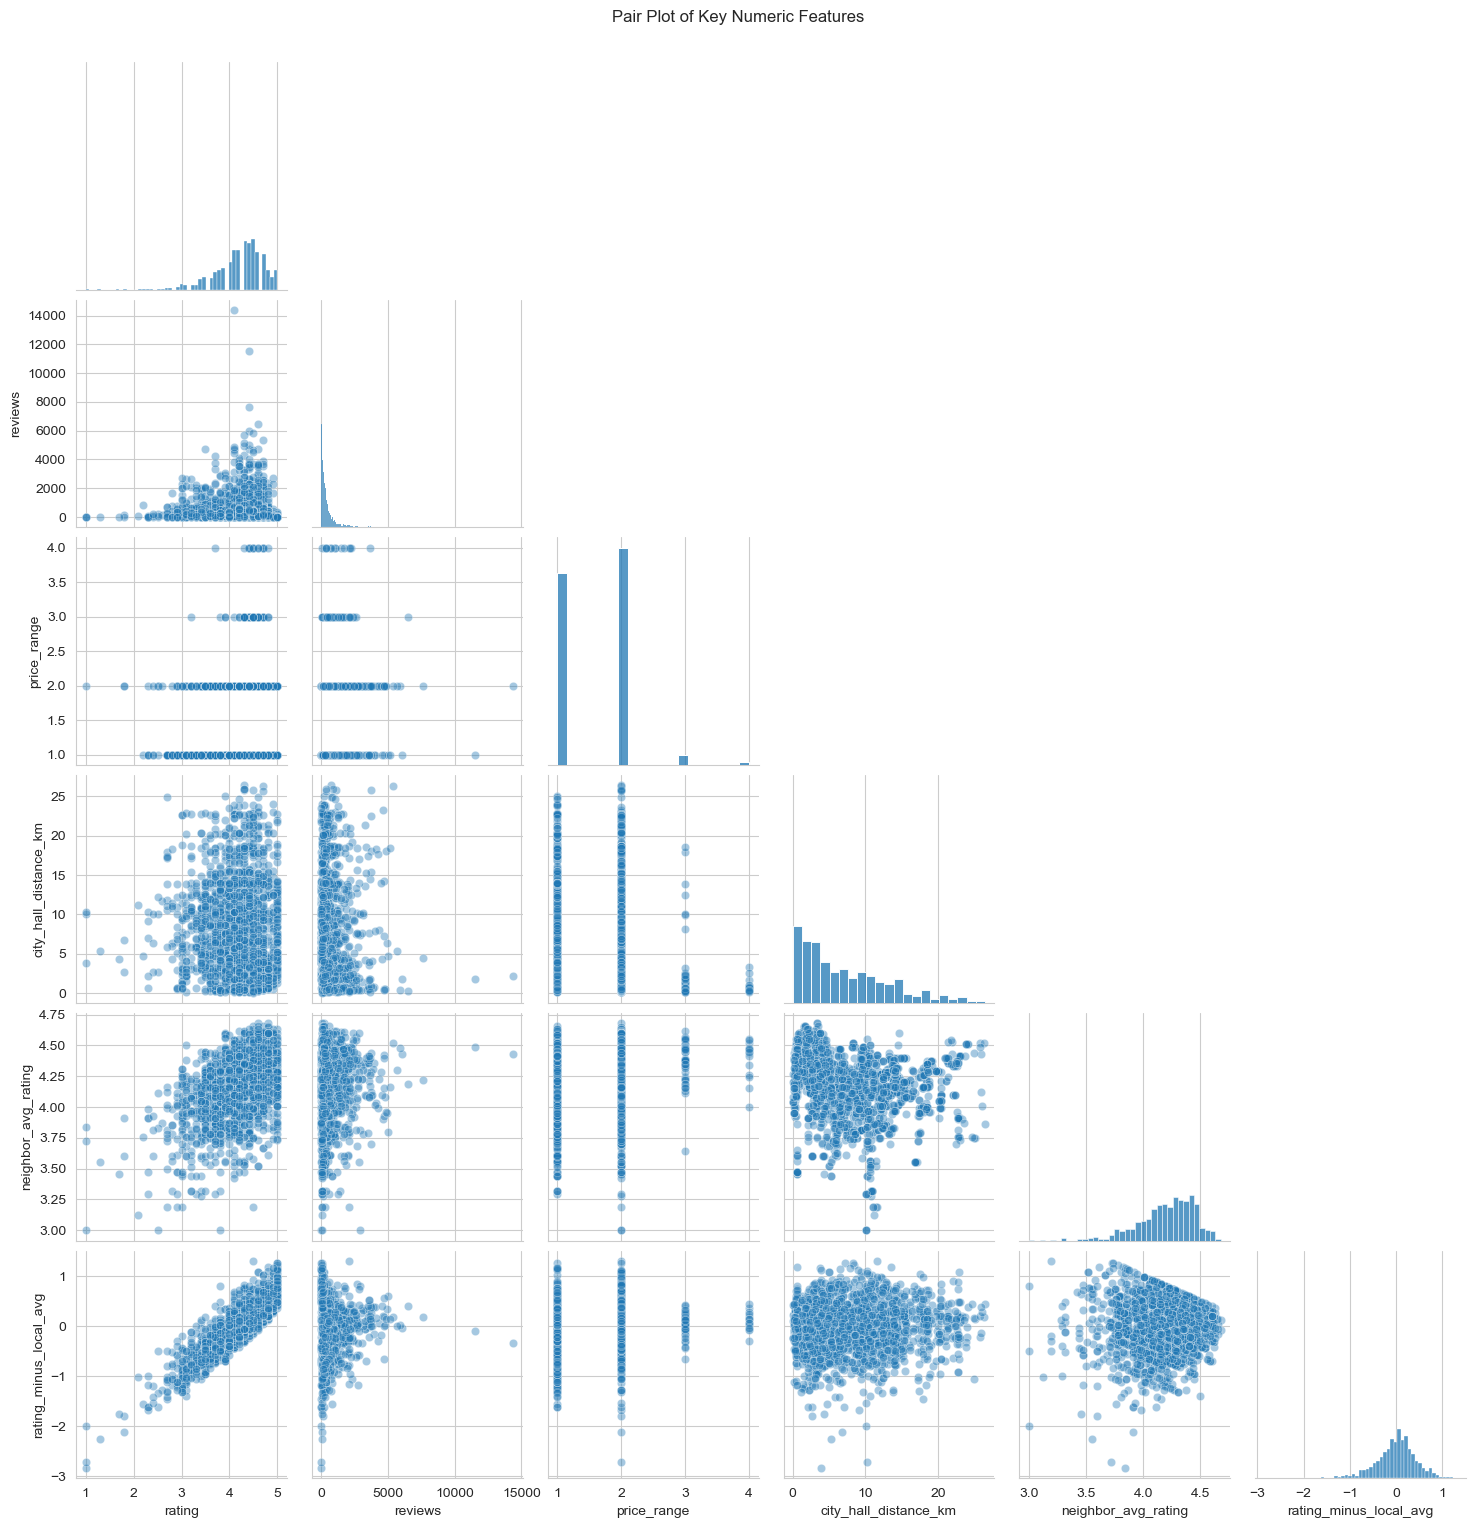

In [49]:
#Pair plots

pairplot_features = df_train[[
    'rating',
    'reviews',
    'price_range',
    'city_hall_distance_km',
    'neighbor_avg_rating',
    'rating_minus_local_avg'
]]

# Create the pairplot
sns.pairplot(pairplot_features, corner=True, plot_kws={'alpha': 0.4})
plt.suptitle("Pair Plot of Key Numeric Features", y=1.02)
plt.show()

It looks to me like there is some data captured in reviews that isn't showing up in a correlation

# Census data

In [ ]:
import cenpy
import census

In [55]:
# Connect to 5-year ACS dataset (e.g., 2021)
acs = cenpy.products.ACS(2019)

# Check that the variable exists
print(acs.variables['B19013_001E']['label'])  # Should say "Median household income in the past 12 months"

# Query data for Philadelphia County (state=42, county=101)
df = acs.from_county(
    county="Philadelphia",
    state="PA",
    level="tract",
    variables=["B19013_001E"]
)

# Preview the results
print(df.head())

KeyError: 'B19013_001E'

In [56]:
from census import Census

In [70]:
CENSUS_API_KEY = "a92be9495033f153a94ad2fb2b9a95a7658c17a2"
c = Census(CENSUS_API_KEY)

In [72]:
# Example: Get median household income (ACS 5-year) for ZIP Code Tabulation Areas (ZCTAs)
income_data = c.acs5.state_zipcode(
    ["B19013_001E"],  # Variable for median household income
    state_fips = "42",
    zcta ='19103'
)

print(income_data)

[{'B19013_001E': 93740.0, 'zip code tabulation area': '19103'}]


In [73]:
import requests

In [90]:
#code I found online to get census tract of a location
def get_census_tract(lat, lon):
    url = "https://geocoding.geo.census.gov/geocoder/geographies/coordinates"
    params = {
        "x": lon,
        "y": lat,
        "benchmark": "Public_AR_Current",
        "vintage": "Current_Current",
        "format": "json"
    }
    response = requests.get(url, params=params)
    data = response.json()
    
    try:
        tract_info = data['result']['geographies']['Census Tracts'][0]
        return {
            "tract": tract_info['TRACT'],
            "county": tract_info['COUNTY'],
            "state": tract_info['STATE'],
            "geoid": tract_info['GEOID']
        }
    except Exception as e:
        return None

In [ ]:
cen = get_census_tract(39.95110, -75.17873)
print(cen['tract'])

In [103]:
data = c.acs5.state_county_tract(
    ["B19013_001E"],
    state_fips=cen["state"],
    county_fips=cen["county"],
    tract=cen["tract"]
)

In [104]:
print(data)

[{'B19013_001E': 126726.0, 'state': '42', 'county': '101', 'tract': '000801'}]


### some fields we might want to query:

Median Household Income (B19013_001E)

Poverty Rate (% Below poverty level) (B17001_002E / B17001_001E)

Education level (% with Bachelor's Degree or Higher) B15003

Race/Ethnicity data:

Total Population B02001_001E

pct White	B02001_002E / tot pop

pct Black B02001_003E / tot pop

pct Asian B02001_005E / tot pop

pct Hispanic/Latino B03003_003E / tot pop (ethnicity tracked differently)

Immigration data:
% Foreign Born Immigrant B05002_013E / B05002_001E

Age data:
Median Age B01002_001E
% Age 20–34 B01001 (age/sex table)

Neighborhood turnover:
Neighborhood turnover B07003_017E / B07003_001E

